# CSE 190: Fairness, bias, and transparency in Machine Learning

# Assignment 2


In [94]:
import os
import kagglehub
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report

## <ins>Exploratory analysis and fairness metrics</ins>



In [95]:
dataset_path = kagglehub.dataset_download("utkarshx27/which-resume-attributes-drive-job-callbacks")
df = pd.read_csv(dataset_path + "/resume.csv")
print(df.shape)
df.head()


(4870, 30)


,job_ad_id,job_city,job_industry,job_type,job_fed_contractor,job_equal_opp_employer,job_ownership,job_req_any,job_req_communication,job_req_education,...,honors,worked_during_school,years_experience,computer_skills,special_skills,volunteer,military,employment_holes,has_email_address,resume_quality
0,384,Chicago,manufacturing,supervisor,NaN,1,unknown,1,0,0,...,0,0,6,1,0,0,0,1,0,low
1,384,Chicago,manufacturing,supervisor,NaN,1,unknown,1,0,0,...,0,1,6,1,0,1,1,0,1,high
2,384,Chicago,manufacturing,supervisor,NaN,1,unknown,1,0,0,...,0,1,6,1,0,0,0,0,0,low
3,384,Chicago,manufacturing,supervisor,NaN,1,unknown,1,0,0,...,0,0,6,1,1,1,0,1,1,high
4,385,Chicago,other_service,secretary,0.0,1,nonprofit,1,0,0,...,0,1,22,1,0,0,0,0,1,high


#### Dataset Context:

The dataset was collected to analyze how the perceived race of a job applicant (as indicated by their name) affects their chances of receiving a callback from employers. The study investigates whether White-sounding names receive more callbacks than African American-sounding names, controlling for resume quality and other factors.
<br/><br/>

Dataset Collection:
- Researchers sent out 4870 fake resumes in response to 1,344 job postings in newspapers from Chicago and Boston.
- Each job posting received four resumes, two of higher quality and two of lower quality.
- Half of the resumes were assigned White-sounding names (e.g., Emily Walsh, Greg Baker), and the other half were assigned African American-sounding names (e.g., Lakisha Washington, Jamal Jones).
- Researchers then tracked which resumes received callbacks from employers.
<br/><br/>

Dataset features:
- Name assigned to the resume (name is meant to communicate the applicant's gender and race.)
- Resume features
  - Inferred gender associated with the first name on the resume
  - Inferred race associated with the first name on the resume
  - Years of college education listed on the resume
  - Indicator for if the resume listed a college degree
  - Indicator for if the resume listed that the candidate has been awarded some honors
  - Indicator for if the resume listed working while in school
  - Years of experience listed on the resume
  - Indicator for if computer skills were listed on the resume
  - Indicator for if any special skills were listed on the resume
  - Indicator for if volunteering was listed on the resume
  - Indicator for if military experience was listed on the resume
  - Indicator for if there were holes in the person's employment history
  - Indicator for if the resume lists an email address
  - Each resume was generally classified as either lower or higher quality
- Job ad details
  - City where the job was located
  - Industry of the job
  - Type of role
  - Indicator for if the employer is a federal contractor
  - Indicator for if the employer is an Equal Opportunity Employer
  - The type of company, e.g. a nonprofit or a private company
  - Indicator for if any job requirements are listed. If so, the other job_req_* fields give more detail
  - Indicator for if communication skills are required
  - Indicator for if some level of education is required
  - Amount of experience required
  - Indicator for if computer skills are required
  - Indicator for if organization skills are required
  - Level of education required
  - Indicator for if there was a callback from the job posting for the person listed on this resume
- Indicator for if there was a callback from the job posting for the person listed on this resume

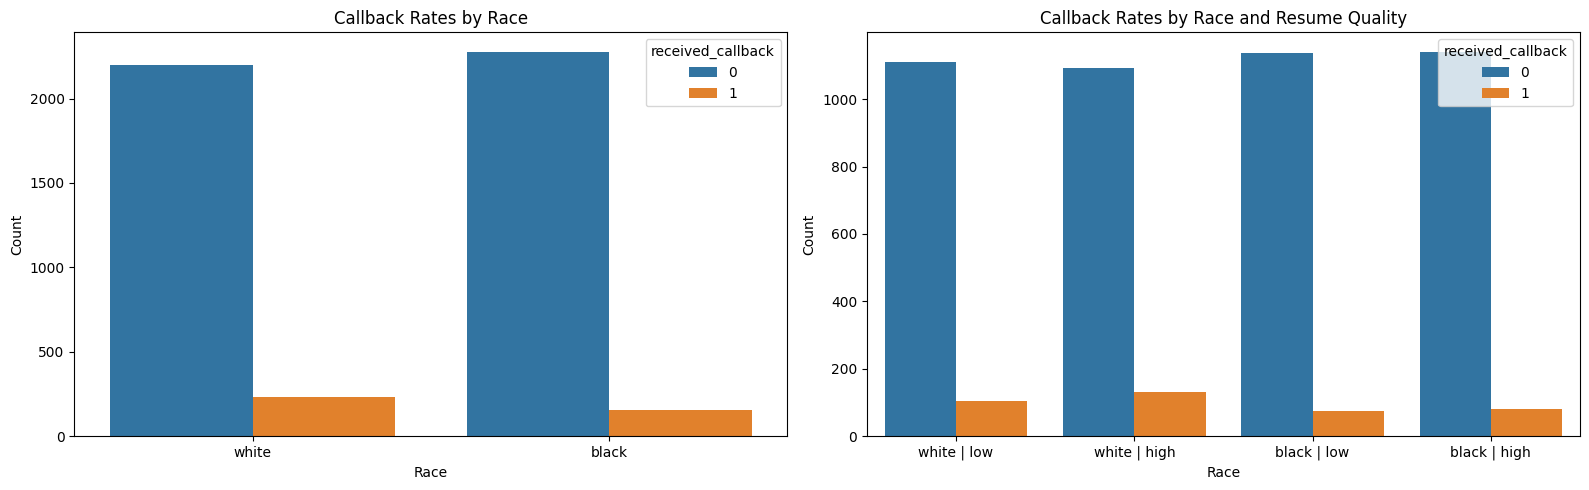

In [96]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

sns.countplot(x="race", hue="received_callback", data=df, ax=axes[0])
axes[0].set_xlabel("Race")
axes[0].set_ylabel("Count")
axes[0].set_title("Callback Rates by Race")

df['race_resume'] = df['race'].astype(str) + " | " + df['resume_quality'].astype(str)
sns.countplot(x="race_resume", hue="received_callback", data=df, ax=axes[1])
axes[1].set_xlabel("Race")
axes[1].set_ylabel("Count")
axes[1].set_title("Callback Rates by Race and Resume Quality")
plt.tight_layout()
plt.show()

df = df.drop(columns=['race_resume'])
# print(df.isnull().sum())

### Graphs

1. Callback Rates by Race
    - We see that the white resumes are recieving a high number of callbacks than black resumes.
<br/><br/>

1. Callback Rates by Race and Resume Quality
    - We also compare the resume quality in the second graph because it could be the case that black people have lower quality resume so they get less callbacks. But we see that Black applicants with high-quality resumes (~6.5%) receive fewer callbacks than white applicants with low-quality resumes (~8.5%). This indicats that bias exists in the original dataset even when we factor resume quality in. 


### Data Cleaning

1. We will convert race, gender, and resume quality to binary labels.
   - race: White -> 0, Black -> 1
   - gender: Male (m) -> 0, Female (f) -> 1
   - resume_quality: Low -> 0, High -> 1
<br/><br/>

1. We will drop these features
   - 'firstname' - Does not matter as the first name information is held within the race and gender features
   - job_ad_id – A unique job identifier, not relevant
   - job_city – Not relevant
   - job_industry – Not relevant
   - job_type – The type of job (e.g., full-time, part-time) may not be necessary for our study.
   - job_ownership – Not relevant
   - job_req_min_experience – Not relevant
   - job_req_school – Not relevant
   - job_fed_contractor - lots of NaN

In [97]:
df['race'] = df['race'].map({'white': 0, 'black': 1})
df['gender'] = df['gender'].map({'m': 0, 'f': 1})
df['resume_quality'] = df['resume_quality'].map({'low': 0, 'high': 1})
df = df.drop(columns=['firstname', 'job_ad_id', 'job_city', 'job_industry', 'job_type', 'job_ownership', 'job_req_min_experience', 'job_req_school', 'job_fed_contractor', ])
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4870 entries, 0 to 4869
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   job_equal_opp_employer  4870 non-null   int64
 1   job_req_any             4870 non-null   int64
 2   job_req_communication   4870 non-null   int64
 3   job_req_education       4870 non-null   int64
 4   job_req_computer        4870 non-null   int64
 5   job_req_organization    4870 non-null   int64
 6   received_callback       4870 non-null   int64
 7   race                    4870 non-null   int64
 8   gender                  4870 non-null   int64
 9   years_college           4870 non-null   int64
 10  college_degree          4870 non-null   int64
 11  honors                  4870 non-null   int64
 12  worked_during_school    4870 non-null   int64
 13  years_experience        4870 non-null   int64
 14  computer_skills         4870 non-null   int64
 15  special_skills       

In [98]:
print(df.isnull().sum())

job_equal_opp_employer    0
job_req_any               0
job_req_communication     0
job_req_education         0
job_req_computer          0
job_req_organization      0
received_callback         0
race                      0
gender                    0
years_college             0
college_degree            0
honors                    0
worked_during_school      0
years_experience          0
computer_skills           0
special_skills            0
volunteer                 0
military                  0
employment_holes          0
has_email_address         0
resume_quality            0
dtype: int64


In [99]:
def compute_rates(scores, labels, threshold=0.5):
    scores = np.array(scores)
    labels = np.array(labels)
    preds = (scores >= threshold).astype(int)
    
    tp = np.sum((preds == 1) & (labels == 1))
    fn = np.sum((preds == 0) & (labels == 1))
    fp = np.sum((preds == 1) & (labels == 0))
    tn = np.sum((preds == 0) & (labels == 0))
    
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    tnr = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0
    fnr = fn / (tn + fp) if (tn + fp) > 0 else 0.0

    return tpr, tnr, fpr, fnr

In [100]:
# ---------------------------
# Our data is now clean 
# ---------------------------

X = df.drop(columns=['received_callback'])
y = df['received_callback']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# ---------------------------
# Logistic Regression Model
# ---------------------------
clf_lr = LogisticRegression(class_weight="balanced", max_iter=1000)
clf_lr.fit(X_train, y_train)
y_pred_lr = clf_lr.predict(X_test)

accuracy_lr = accuracy_score(y_test, y_pred_lr)
balanced_acc_lr = balanced_accuracy_score(y_test, y_pred_lr)

print("Logistic Regression Results:")
print(f"Accuracy: {accuracy_lr:.4f}")
print(f"Balanced Accuracy: {balanced_acc_lr:.4f}\n")

# ---------------------------
# Support Vector Machine Model
# ---------------------------
clf_svm = SVC(class_weight="balanced", max_iter=-1)  # max_iter=-1 for no limit
clf_svm.fit(X_train, y_train)
y_pred_svm = clf_svm.predict(X_test)

accuracy_svm = accuracy_score(y_test, y_pred_svm)
balanced_acc_svm = balanced_accuracy_score(y_test, y_pred_svm)

print("Support Vector Machine Results:")
print(f"Accuracy: {accuracy_svm:.4f}")
print(f"Balanced Accuracy: {balanced_acc_svm:.4f}\n")

# ---------------------------
# Decision Tree Model
# ---------------------------
clf_tree = DecisionTreeClassifier(class_weight="balanced", random_state=42)
clf_tree.fit(X_train, y_train)
y_pred_tree = clf_tree.predict(X_test)

accuracy_tree = accuracy_score(y_test, y_pred_tree)
balanced_acc_tree = balanced_accuracy_score(y_test, y_pred_tree)

print("Decision Tree Results:")
print(f"Accuracy: {accuracy_tree:.4f}")
print(f"Balanced Accuracy: {balanced_acc_tree:.4f}\n")

# ---------------------------
# Random Forest Classifier
# ---------------------------
clf_Forest = RandomForestClassifier(n_estimators=300, max_depth=5, class_weight='balanced')

clf_Forest.fit(X_train, y_train)
y_pred_tree = clf_Forest.predict(X_test)

accuracy_tree = accuracy_score(y_test, y_pred_tree)
balanced_acc_tree = balanced_accuracy_score(y_test, y_pred_tree)

print("Random Forest Results:")
print(f"Accuracy: {accuracy_tree:.4f}")
print(f"Balanced Accuracy: {balanced_acc_tree:.4f}")

y_pred = y_pred_tree

Logistic Regression Results:
Accuracy: 0.6386
Balanced Accuracy: 0.6397

Support Vector Machine Results:
Accuracy: 0.5893
Balanced Accuracy: 0.5837

Decision Tree Results:
Accuracy: 0.7957
Balanced Accuracy: 0.5671

Random Forest Results:
Accuracy: 0.7351
Balanced Accuracy: 0.6161


In [101]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

def fairness_metrics(y_true, y_pred, sensitive_feature):
    group_0 = (sensitive_feature == 0)
    group_1 = (sensitive_feature == 1)

    def compute_tpr(y_true_group, y_pred_group):
        tp = np.sum((y_pred_group == 1) & (y_true_group == 1))
        fn = np.sum((y_pred_group == 0) & (y_true_group == 1))
        return tp / (tp + fn) if (tp + fn) > 0 else 0

    def compute_fpr(y_true_group, y_pred_group):
        fp = np.sum((y_pred_group == 1) & (y_true_group == 0))
        tn = np.sum((y_pred_group == 0) & (y_true_group == 0))
        return fp / (fp + tn) if (fp + tn) > 0 else 0

    tpr_0 = compute_tpr(y_true[group_0], y_pred[group_0])
    tpr_1 = compute_tpr(y_true[group_1], y_pred[group_1])
    fpr_0 = compute_fpr(y_true[group_0], y_pred[group_0])
    fpr_1 = compute_fpr(y_true[group_1], y_pred[group_1])

    return tpr_0, fpr_0, tpr_1, fpr_1

def accuracy_parity(y_true, y_pred, sensitive_feature):
    group_0 = (sensitive_feature == 0)
    group_1 = (sensitive_feature == 1)
    acc_0 = np.mean(y_true[group_0])
    acc_1 = np.mean(y_true[group_1])
    return abs(acc_0 - acc_1), acc_0, acc_1

def demographic_parity(y_pred, sensitive_feature):
    group_0 = (sensitive_feature == 0)
    group_1 = (sensitive_feature == 1)
    pos_rate_0 = np.mean(y_pred[group_0])
    pos_rate_1 = np.mean(y_pred[group_1])
    return abs(pos_rate_0 - pos_rate_1), pos_rate_0, pos_rate_1

def generalized_fdr(y_true, y_pred, sensitive_feature):
    def compute_fdr(y_true_group, y_pred_group):
        fp = np.sum((y_pred_group == 1) & (y_true_group == 0))
        tp = np.sum((y_pred_group == 1) & (y_true_group == 1))
        return fp / (fp + tp) if (fp + tp) > 0 else 0

    group_0 = (sensitive_feature == 0)
    group_1 = (sensitive_feature == 1)
    fdr_0 = compute_fdr(y_true[group_0], y_pred[group_0])
    fdr_1 = compute_fdr(y_true[group_1], y_pred[group_1])
    return abs(fdr_0 - fdr_1), fdr_0, fdr_1

def compute_PPV_NPV_PerGroup(y_true, y_pred, sensitive_feature):
    def compute_PPV_NPV(y_true_group, y_pred_group):
        cm = confusion_matrix(y_true_group, y_pred_group)
        TN, FP, FN, TP = cm.ravel()
        PPV = TP / (TP + FP) if (TP + FP) > 0 else 0
        NPV = TN / (TN + FN) if (TN + FN) > 0 else 0
        return PPV, NPV
    
    group_0 = (sensitive_feature == 0)
    group_1 = (sensitive_feature == 1)
    PPV_0, NPV_0 = compute_PPV_NPV(y_true[group_0], y_pred[group_0])
    PPV_1, NPV_1 = compute_PPV_NPV(y_true[group_1], y_pred[group_1])
    return PPV_0, NPV_0, PPV_1, NPV_1

import numpy as np

def per_group_prevalence(y_true, sensitive_feature):
    group_0 = (sensitive_feature == 0)
    group_1 = (sensitive_feature == 1)
    
    prevalence_0 = np.mean(y_true[group_0] == 1)
    prevalence_1 = np.mean(y_true[group_1] == 1)
    return prevalence_0, prevalence_1


prevalence_0, prevalence_1 = per_group_prevalence(y_test, X_test['race'].to_numpy())
tpr_0, fpr_0, tpr_1, fpr_1 = fairness_metrics(y_test, y_pred, X_test['race'].to_numpy())
PPV_0, NPV_0, PPV_1, NPV_1 = compute_PPV_NPV_PerGroup(y_test, y_pred, X_test['race'].to_numpy())

acc_parity, acc_0, acc_1 = accuracy_parity(y_test, y_pred, X_test['race'].to_numpy())
dem_parity, pos_rate_0, pos_rate_1 = demographic_parity(y_pred, X_test['race'].to_numpy())
gen_fdr, fdr_0, fdr_1 = generalized_fdr(y_test, y_pred, X_test['race'].to_numpy())

print("\nFairness Metrics (Race as Sensitive Attribute):")
print(f"Prevalence for Group 0 - white: \t{prevalence_0:.4f}")
print(f"Prevalence_1 for Group 1 - black: \t{prevalence_1:.4f}\n")

print(f"TPR (Group 0 - white): {tpr_0:.4f}")
print(f"TPR (Group 1 - black): {tpr_1:.4f}")
print(f"FPR (Group 0 - white): {fpr_0:.4f}")
print(f"FPR (Group 1 - black): {fpr_1:.4f}\n")

print(f"PPV (Group 0 - white): {PPV_0:.4f}")
print(f"PPV (Group 1 - black): {PPV_1:.4f}")
print(f"NPV (Group 0 - white): {NPV_0:.4f}")
print(f"NPV (Group 1 - black): {NPV_1:.4f}\n")

print(f"Equal Opportunity (TPR difference): {abs(tpr_0 - tpr_1):.4f}\n")

print(f"Accuracy: Group 0 = {acc_0:.4f}, Group 1 = {acc_1:.4f}, Accuracy Parity = {acc_parity:.4f}\n")

print(f"Demographic Parity: Group 0 Positive Rate = {pos_rate_0:.4f}, Group 1 Positive Rate = {pos_rate_1:.4f}, Difference = {dem_parity:.4f}\n")

print(f"Generalized FDR: Group 0 = {fdr_0:.4f}, Group 1 = {fdr_1:.4f}, Difference = {gen_fdr:.4f}\n")


Fairness Metrics (Race as Sensitive Attribute):
Prevalence for Group 0 - white: 	0.0991
Prevalence_1 for Group 1 - black: 	0.0627

TPR (Group 0 - white): 0.5652
TPR (Group 1 - black): 0.3438
FPR (Group 0 - white): 0.3038
FPR (Group 1 - black): 0.1883

PPV (Group 0 - white): 0.1699
PPV (Group 1 - black): 0.1089
NPV (Group 0 - white): 0.9357
NPV (Group 1 - black): 0.9487

Equal Opportunity (TPR difference): 0.2215

Accuracy: Group 0 = 0.0991, Group 1 = 0.0627, Accuracy Parity = 0.0364

Demographic Parity: Group 0 Positive Rate = 0.3297, Group 1 Positive Rate = 0.1980, Difference = 0.1317

Generalized FDR: Group 0 = 0.8301, Group 1 = 0.8911, Difference = 0.0610



### Discussion
1. Prevalence Disparity

    The prevalence rate for the white group is 0.0991, whereas for black group it is 0.0627. This suggests that the positive outcome is more frequent for the white group than the black group. 

2. True Positive Rate (TPR) Disparity (Equal Opportunity)

    The white group TPR is 0.5652, while the black group TPR = 0.3125. This means that the model correctly identifies positive cases for the white group at a much higher rate than for the black group.

    The Equal Opportunity difference (TPR difference) is 0.2527, indicating a significant disparity.

    This suggests potential discrimination against Group 1, as they are less likely to receive a correct positive prediction.

3. False Positive Rate (FPR) Disparity

    The white group FPR is 0.3134, while the black group FPR is 0.1653.

    The white group has a higher rate of false positives, this means they are incorrectly classified as positive more often.

    The FPR amd TPR for the white group suggest being a white applicant will mean you will have a higher chance at getting a callback

4. Accuracy & Accuracy Parity

    Accuracy for the white group is 0.6746, while for the black group it's 0.8020, therefore we have an accuracy disparity of 0.1274.

    The model is more accurate for the black group, meaning it performs better overall for this group.

    However, the lower TPR for the black group suggests that this higher accuracy could be due to the fact that the model is predicting no callback for this group majority of the time. Also looking at the the FPR of the white group it tells us that the accuracy for the white group is lower because we are getting a lot more false positives.

5. Demographic Parity (Overall Selection Rate)

    Positive rate for the white group is 0.3384, while for the black group it's 0.1745, resulting in a gap of 0.1639.

    This means that the white group is more likely to be assigned a positive outcome overall, leading a potential bias in the models decision-making.

### Summary
- We have a significant TPR gap (0.2527) which means we have an Equal Opportunity violation, where the black group is a lot less likely to receive correct positive predictions.
- Demographic parity difference (0.1639) indicates the white group is disproportionately receiving positive outcomes.
- Accuracy is higher for the black group, but this could be due to fewer false positives.
- Fairness interventions is necessary.

## <ins>Interventions</ins>

4. Code: How much can “unfairness” in your predictions be explained by dataset
characteristics? Can you fix them with dataset-based interventions?

    Say a little something about the code cell for 4.

In [102]:
# 4. Code

5. Code: How do different modeling choices impact fairness characteristics? Can
you fix them with in-processing interventions?

    Say a little something about different modeling choices impacting fairness, and in-processing intervention

In [103]:
# 5. Code

6. Code: Can you apply post-processing interventions to achieve desired fairness
outcomes?

    Talk about post processing intervention for the following code cell

In [104]:
# 6. Code

7. Discussion: What types of interventions are most appropriate for your task (e.g.
legal, practical to deploy, etc.)? What are the tradeoffs between them (e.g. how
are other metrics negatively impacted by a particular intervention, etc.)

## <ins>Research Paper</ins>

8. Context: Summarize the main contributions of the paper and its relevance to
your task.

9. Code: Attempt to reproduce results similar to those reported in the paper on your
dataset (or comment in detail about any failure to do so)

    Say something like in the following code cell we will attempt to reproduce these results

In [105]:
# 9. Code

10. Discussion: Is it more effective than other intervention strategies you tried? Why
or why not? Conclude your presentation with a general discussion of what was
and was not effective for your task.